In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

**Imports for image reading**

In [ ]:
import PIL
from PIL import Image
from matplotlib import image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.0.0


Imports for modeling:

In [ ]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers 
from tensorflow.keras import Model
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import gc

In [ ]:
gc.collect()

0

In [ ]:
#The followig code allows me to mount my google drive directory to colab, where my image files were stored for this project
from google.colab import drive

In [ ]:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
%matplotlib inline

## Reading in Data from Drive 
---

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = '/content/gdrive/MyDrive/Colab Notebooks/data/Data_Entry_2017_v2020.csv'

In [ ]:
df = pd.read_csv(path)

In [ ]:
df.columns = df.columns.map({col:col.lower().replace(' ','_') for col in df.columns})

In [ ]:
df.finding_labels[50:55]

50                 Emphysema|Pneumothorax
51               Atelectasis|Pneumothorax
52                           Pneumothorax
53    Cardiomegaly|Emphysema|Pneumothorax
54                             No Finding
Name: finding_labels, dtype: object

In [ ]:
labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 
          'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']

In [ ]:
#Trying to reduce the number of unique instances
df['is_positive_finding'] = df.finding_labels.apply(lambda x: 'No Finding' if x == 'No Finding' else 'Positive Finding')

In [ ]:
df.is_positive_finding.value_counts() #112120

No Finding          60361
Positive Finding    51759
Name: is_positive_finding, dtype: int64

Method for building generator and this count are from [this site](https://godatadriven.com/blog/keras-multi-label-classification-with-imagedatagenerator/)

In [ ]:
df.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],is_positive_finding
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,Positive Finding
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,Positive Finding
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,Positive Finding
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,No Finding
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,Positive Finding
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,Positive Finding
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,Positive Finding
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,Positive Finding
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,Positive Finding
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143,Positive Finding


## Image data (Modelling Features)
---

In [ ]:
#making a file patient num and file image num column, then sorting
print(int(df.image_index[0].split('_')[0]))
df['fpt_num'] = df.image_index.apply(lambda x: int(x.split('_')[0]))
df['fimg_num'] = df.image_index.apply(lambda x: int(x.split('_')[1].split('.')[0]))

1


In [ ]:
arranger = df.sort_values(by = ['fpt_num', 'fimg_num']).reset_index()

In [ ]:
arranger.tail(12)

,index,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],is_positive_finding,fpt_num,fimg_num
112108,112108,00030795_000.png,Pleural_Thickening,0,30795,52,F,PA,2021,2021,0.194311,0.194311,Positive Finding,30795,0
112109,112109,00030796_000.png,No Finding,0,30796,43,M,PA,2021,2021,0.194311,0.194311,No Finding,30796,0
112110,112110,00030797_000.png,No Finding,0,30797,23,M,PA,2021,2021,0.194311,0.194311,No Finding,30797,0
112111,112111,00030798_000.png,No Finding,0,30798,29,M,PA,2500,2048,0.171000,0.171000,No Finding,30798,0
112112,112112,00030799_000.png,No Finding,0,30799,32,M,PA,2048,2500,0.171000,0.171000,No Finding,30799,0
112113,112113,00030800_000.png,No Finding,0,30800,33,F,PA,2048,2500,0.168000,0.168000,No Finding,30800,0
112114,112114,00030801_000.png,No Finding,0,30801,38,M,PA,2500,2048,0.168000,0.168000,No Finding,30801,0
112115,112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168000,0.168000,Positive Finding,30801,1
112116,112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168000,0.168000,No Finding,30802,0
112117,112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168000,0.168000,No Finding,30803,0


In [ ]:
df = arranger.drop(columns = 'index')
df.drop(columns = ['fpt_num', 'fimg_num'], inplace = True)

In [ ]:
df.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],is_positive_finding
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,Positive Finding
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,Positive Finding
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,Positive Finding
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,No Finding
4,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,0.143,Positive Finding
5,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,Positive Finding
6,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,Positive Finding
7,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,Positive Finding
8,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,Positive Finding
9,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,Positive Finding


It appears that the original indices phased in and out with this new index. That's why my x ray image in my array and my sub list were only off by a few images.

## Getting the Subset Data from the DF
---

In [ ]:
#This function pointed my flow from dataframe method below to each image, as searching for sub-directories is not allowed by
#keras' flow from dataframe method presently. Note that I manually moved many images to folder 1 at first before attempting this, 
#which is why several images display in that folder, and it leaps to directory images_5

def path_setup():
    path = '/content/gdrive/MyDrive/Capstone_Images/'
    all_dfs = []
    midpath = ['images/', 'images_5/', 'images_6/', 'images_7/', 'images_8/', 
               'images_9/','images_10/','images_11/', 'images_12/']
    
    low = ['000000001_000.png', '00010927_001.png','00011558_008.png','00013774_026.png','00016051_010.png',
          '00018387_035.png', '00020945_050.png','00024718_000.png','00028173_003.png']
    high = ['00010927_001.png','00011558_008.png','00013774_026.png','00016051_010.png','00018387_035.png',
           '00020945_050.png','00024718_000.png','00028173_003.png','00030805_000.png']
    
    for i,j,k in zip(low, high, midpath):
        if i == '000000001_000.png':
            df_sub = df.iloc[: df[df.image_index == j].index.values[0]]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
            
        elif j == '00030805_000.png':
            df_sub = df.iloc[df[df.image_index == i].index.values[0]:]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
            
        else:
            df_sub = df.iloc[df[df.image_index == i].index.values[0]: df[df.image_index == j].index.values[0]]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
    
    new_df = pd.concat(all_dfs)
    print(len(all_dfs) == 9)
    return new_df

In [ ]:
df_sub = path_setup()

True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
df_sub.tail()

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],is_positive_finding,path
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168,No Finding,/content/gdrive/MyDrive/Capstone_Images/images...
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,No Finding,/content/gdrive/MyDrive/Capstone_Images/images...
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168,No Finding,/content/gdrive/MyDrive/Capstone_Images/images...
112119,00030805_000.png,No Finding,0,30805,26,M,PA,2048,2500,0.171,0.171,No Finding,/content/gdrive/MyDrive/Capstone_Images/images...


In [ ]:
#I have verified that each subset of image indices matches what is in my folders
df_sub.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],is_positive_finding,path
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,No Finding,/content/gdrive/MyDrive/Capstone_Images/images...
4,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,0.143,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
5,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
6,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
7,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
8,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
9,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...


In [ ]:
df_sub.shape[0]

112120

EXCELLENT! Now I can model

## Model of Subset Data
---

In [ ]:
print(labels)

['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']


In [ ]:
df_flow = df_sub[['path', 'is_positive_finding']].reset_index()
df_flow['index'] = df_flow.index

#Comment this out when actually saving/loading weights! This was only for the purposes of making visualizations of 10 epochs 
df_flow = df_flow.sample(frac = 0.4)

In [ ]:
df_flow.head()

,index,path,is_positive_finding
109177,109177,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding
3218,3218,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
9005,9005,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
51222,51222,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding
91370,91370,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding


In [ ]:
fullpath = '/content/gdrive/MyDrive/Capstone_Images/images'

In [ ]:
#path = '/content/gdrive/MyDrive/Capstone_Images/test_dir'  vertical_flip = True,
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2,  rotation_range = 0.3, 
                             horizontal_flip = True, vertical_flip = True)

In [ ]:
training = datagen.flow_from_dataframe(dataframe = df_flow, directory = None,
                                   x_col = 'path', y_col = 'is_positive_finding',
                                    class_mode = 'binary', seed = 42,
                                    subset = 'training',
                                   batch_size = 16, target_size = (224, 224),
                                   color_mode = 'rgb')

Found 34512 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1709 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
test = datagen.flow_from_dataframe(dataframe = df_flow, directory = None,
                                   x_col = 'path', y_col = 'is_positive_finding',
                                    class_mode = 'binary', seed = 42,
                                    subset = 'validation',
                                   batch_size = 16, target_size = (224, 224),
                                   color_mode = 'rgb')

Found 8627 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1709 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
training.n, test.n

(34512, 8627)

In [ ]:
df_flow

,index,path,is_positive_finding
109177,109177,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding
3218,3218,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
9005,9005,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
51222,51222,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding
91370,91370,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
...,...,...,...
31965,31965,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
69514,69514,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding
73712,73712,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
38443,38443,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding


In [ ]:
final_labels = ['No Finding', 'Positive Finding']
final_labels

['No Finding', 'Positive Finding']

In [ ]:
#Instructs the model on how many steps to take for each epoch
step_train=training.n//training.batch_size
step_test=test.n//test.batch_size

In [ ]:
#The first model I attempted to build out, before employing transfer learning (extremely long run times as I tried to keep original
#input sizes)

# model = Sequential()

# model.add(Conv2D(filters = 24, kernel_size = (3, 3), activation = 'relu', input_shape = (1024, 1024, 1)))
# model.add(MaxPool2D(pool_size = (2, 2)))

# model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))

# model.add(Conv2D(34, kernel_size = (3, 3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))

# model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))

# #kernel_regularizer = l2(0.002)

# model.add(Flatten())
# #model.add(Dense(1200, activation = 'relu'))
# #model.add(Dense(800, activation = 'relu',kernel_regularizer = l2(0.002)))
# #model.add(Dense(300, activation = 'relu'))

# #model.add(Dense(164, activation = 'relu'))

# model.add(Dense(56, activation = 'relu'))
# model.add(Dropout(0.5))

# model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
#Base model loaded from keras, outputs to my top layer, then get compiled together as one model
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    classes = 2,
    pooling = 'avg',
    input_shape=(224, 224, 3)#(1024, 1024, 3)
)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

#Experimenting with unfreezing some layers to see if there's benefit to mixing transfer learning with training from scratch
# for layer in base_model.layers[:60]:
#     layer.trainable=False
# for layer in base_model.layers[60:]:
#     layer.trainable=True

In [ ]:
x=base_model.output
x=Flatten()(x)  #GlobalAveragePooling2D

#x=Dense(10024,activation='relu')(x)
x=Dense(10024,activation='relu')(x)
x=Dense(5024,activation='relu')(x) #we add dense layers so that the model can learn more 
#complex functions and classify for better results.
x=Dense(2024,activation='relu')(x)
#x = layers.Dropout(0.4)(x)
x=Dense(1024,activation='relu')(x) #dense layer 2
#x = layers.Dropout(0.3)(x)
x=Dense(712,activation='relu')(x) #dense layer 3
#x = layers.Dropout(0.3)(x)

#Don't dropout anymore. Instead, do data augmentation by rotating/flipping your images!

In [ ]:

x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
epoch = 10
cnn_path = '/content/gdrive/MyDrive/cnn_weights/binary_transfer/'

#save the model weights in case they improve
model_checkpoint_callback = ModelCheckpoint(
    filepath = cnn_path,
    save_weights_only=True,
    monitor='val_loss',#'loss',
    mode= 'min',
    save_freq = 'epoch',#300,
    save_best_only=True,
    verbose = 1)

In [ ]:
model.load_weights(cnn_path) #--> will load in the model weights after you have made some

result = model.fit(training, steps_per_epoch = step_train, 
                    validation_data = test, 
                      validation_steps= step_test, epochs = epoch, callbacks = model_checkpoint_callback)

Epoch 1/10
2157/2157 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.6674
Epoch 00001: val_loss improved from inf to 0.60970, saving model to /content/gdrive/MyDrive/cnn_weights/binary_transfer/
2157/2157 [==============================] - 13836s 6s/step - loss: 0.6172 - accuracy: 0.6674 - val_loss: 0.6097 - val_accuracy: 0.6773
Epoch 2/10
2157/2157 [==============================] - ETA: 0s - loss: 0.6140 - accuracy: 0.6715
Epoch 00002: val_loss improved from 0.60970 to 0.60807, saving model to /content/gdrive/MyDrive/cnn_weights/binary_transfer/
2157/2157 [==============================] - 1365s 633ms/step - loss: 0.6140 - accuracy: 0.6715 - val_loss: 0.6081 - val_accuracy: 0.6779
Epoch 3/10
2157/2157 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.6696
Epoch 00003: val_loss did not improve from 0.60807
2157/2157 [==============================] - 1352s 627ms/step - loss: 0.6136 - accuracy: 0.6696 - val_loss: 0.6425 - val_accuracy: 0.67

## Model Performances
---
BASELINE = 53.8%

**VGG - 16 frozen:**
- train layers = False
- weights = None
- one dense layer, 212 neurons, dropout of 0.2
- Final training accuracy after 10 epochs: 63.27%
- Final test accuracy after 10 epochs: 62.52% accuracy
- train loss: .6439 || test loss: .6252


**MobileNet:**
- train layers [:20] False, [20:] True
- weights = imagenet
- 4 dense layers: 2024, 1024, 512, 1
- Train final: 86.07% Test final: 62.71%



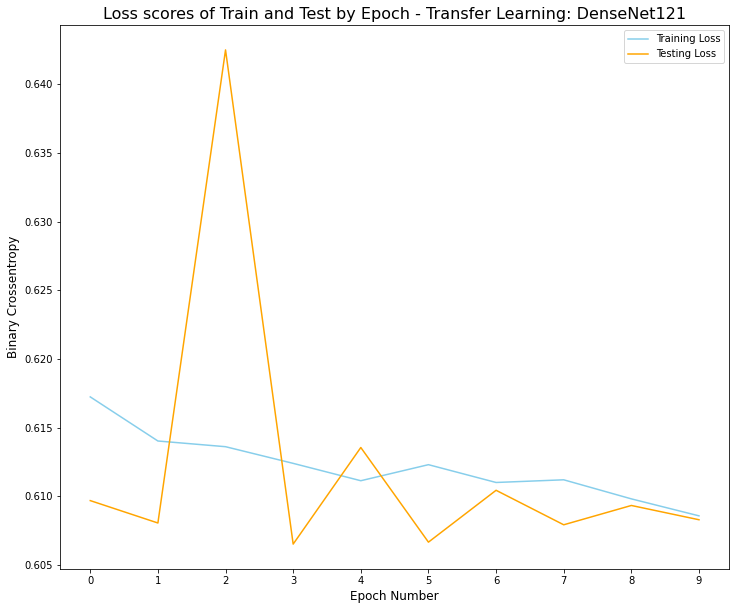

In [ ]:
train_loss = result.history['loss']
test_loss = result.history['val_loss']

plt.figure(figsize = (12, 10))

plt.plot(train_loss, color = 'skyblue', label = 'Training Loss')
plt.plot(test_loss, color = 'orange', label = 'Testing Loss')

plt.title('Loss scores of Train and Test by Epoch - Transfer Learning: DenseNet121', fontsize = 16)
plt.xlabel('Epoch Number', fontsize = 12)
plt.ylabel('Binary Crossentropy', fontsize = 12)
plt.xticks(np.arange(epoch), np.arange(epoch))

plt.legend();

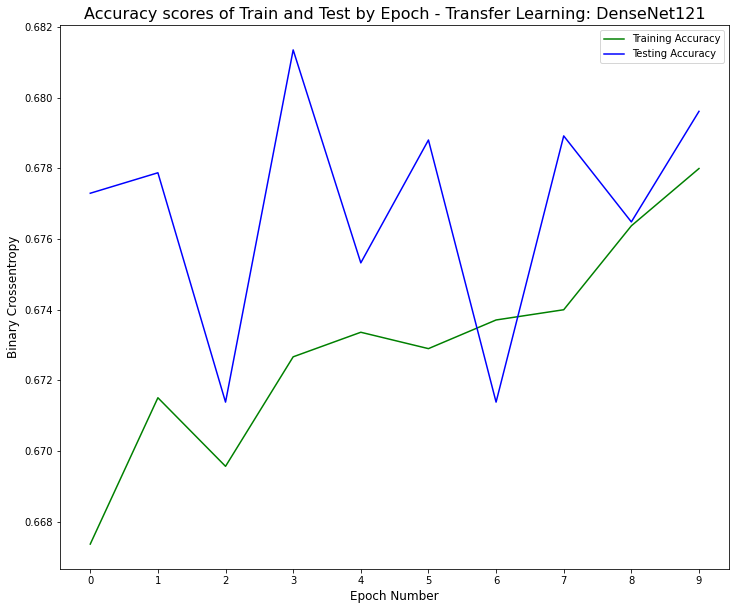

In [ ]:
train_acc = result.history['accuracy']
test_acc = result.history['val_accuracy']

plt.figure(figsize = (12, 10))

plt.plot(train_acc, color = 'green', label = 'Training Accuracy')
plt.plot(test_acc, color = 'blue', label = 'Testing Accuracy')

plt.title('Accuracy scores of Train and Test by Epoch - Transfer Learning: DenseNet121', fontsize = 16)
plt.xlabel('Epoch Number', fontsize = 12)
plt.ylabel('Binary Crossentropy', fontsize = 12)
plt.xticks(np.arange(epoch), np.arange(epoch))

plt.legend();

It does appear that this model will benefit from running more epochs. I will experiment more!

In [ ]:
pred_classes = (model.predict(training) > 0.5).astype("int32")

In [ ]:
pred_classes[0].shape

(1,)

In [ ]:
final_labels = [i for i in training.class_indices.keys()]

In [ ]:
pred_classes[:5]

array([[1],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

In [ ]:
#A few of my images were corrupted - this error was thrown when predictions were made as a result. I will remove those from the project
#in the coming weeks
test_preds = (model.predict(test) >= 0.5).astype("int32")

UnknownError: ignored

In [ ]:
test_preds[:5]

In [ ]:
training.class_indices

In [ ]:
training.index_array

In [ ]:
df_eval = df_flow.iloc[training.index_array]

In [ ]:
df_eval['model_predictions'] = pred_classes

In [ ]:
df_eval.model_predictions = df_eval.model_predictions.apply(lambda x: 'No Finding' if x == 0 else "Positive Finding")


In [ ]:
test_probas = model.predict(test)

FileNotFoundError: ignored

In [ ]:
df_eval.head(40)

In [ ]:
df_eval_test = df_flow.iloc[test.index_array]

In [ ]:
df_eval_test['model_predictions'] = test_preds

In [ ]:
df_eval_test.model_predictions = df_eval_test.model_predictions.apply(lambda x: 'No Finding' if x == 0 else "Positive Finding")


In [ ]:
df_eval_test['y_true'] = df_eval_test.is_positive_finding.apply(lambda x: int(x == 'Positive Finding'))
df_eval_test['y_probas'] = test_probas

In [ ]:
df_eval_test.head(40)

In [ ]:
cm = confusion_matrix(df_eval_test.is_positive_finding, df_eval_test.model_predictions)

From [deeplizard](https://deeplizard.com/learn/video/km7pxKy4UHU)


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['No Finding','Positive Finding']

In [ ]:
plt.figure(figsize = (10,8))
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, normalize = True, title = 'Transfer Learning: DenseNet121');